-------------------------------------------------------------------------------------------------------------------------------
<img align="right" src="https://upload.wikimedia.org/wikipedia/commons/c/c8/Iteso_logo.jpg" width="100" height="100"> 

# <font color='#797983'> **Factset Learning | Otoño 2021.**
### <font color='#1A2478'> **Instituto Tecnológico y de Estudios Superiores de Occidente**.
    
<img align="right" src="Logo_sociedad.png" width="125" height="100" />

**<font color='#797983'>Lecturers:** 
- Juan Pablo Ruíz.
- Bryan Juárez.
    
**<font color='#797983'>Date:** 
- February 9, 2022.
    
### <font color='#797983'> **Portfolio Analysis Module**.
-------------------------------------------------------------------------------------------------------------------------------

**Potential portfolio tickers.**

The tickers to analyze will be a random sample of $400$ tickers from the $\text{S&P500}$ index.

In [1]:
### Libraries to use.
import pandas as pd 
import numpy as np
import yfinance as yf
from datetime import datetime, date
from scipy.optimize import minimize
from CDIN import CDIN as eda
from yahoofinancials import YahooFinancials
import requests
import bs4 as bs
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
### Get the tickers we're interested in. Let's take the random sample of 450 from S&P500.
np.random.seed(5555)

resp = requests.get('http://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
soup = bs.BeautifulSoup(resp.text, 'lxml')
table = soup.find('table', {'class': 'wikitable sortable'})
raw_tickers = []
tickers_adder = raw_tickers.append

for row in table.findAll('tr')[1:]:
    single_ticker = row.findAll('td')[0].text
    tickers_adder(single_ticker)

clean_tickers = [i.replace('\n', '') for i in raw_tickers]

tickers = pd.DataFrame(clean_tickers,
                       columns=['Stock']).sample(n=400)
tickers.head(10)

,Stock
104,CVX
286,LLY
228,HSIC
58,BKR
18,ALB
495,WTW
114,CTXS
226,HCA
53,ATO
497,XEL


**P/E ratio.**

Now In order to reduce the quantity of tickers that will become an input for the optimitazion algorithm, let's use the **P/E ratio** to filter our sample and get the $300$ stocks with the lowest ratio. This means we have the "cheapest" stocks available from the $\text{S&P500}$ index.

In [3]:
### Selected time period. 3 years of historical data.
start_date = '2018-10-01'
end_date = datetime.today().strftime('%Y-%m-%d')

### Make a list of all the available tickers.
tickers_list = tickers['Stock'].tolist()

### Let's substract the stocks info.
stocks_to_watch = tickers_list
yahoo_financials = YahooFinancials(stocks_to_watch)
daily_stock_prices = yahoo_financials.get_historical_price_data(start_date, end_date, 'daily')

In [4]:
### Get the P/E ratio of the stocks.
PE_values = pd.DataFrame.from_dict(yahoo_financials.get_pe_ratio(), orient='index', columns=['P/E ratio'])
PE_values.index.name = 'Stocks'

PE_values.dropna(inplace=True)
PE_values.head(10)

,P/E ratio
Stocks,
CVX,17.020884
LLY,39.795753
HSIC,17.363987
ALB,117.781350
WTW,13.362411
CTXS,41.782340
HCA,10.983978
ATO,20.691406
XEL,23.226350


In [5]:
### Sorting values. Top 300 stocks with the lowest P/E ratio.
n_stocks = 300
best_stocks = PE_values.sort_values(by='P/E ratio')[0:n_stocks]

print('This is the top 10 cheapest stocks:')
best_stocks.head(10)

This is the top 10 cheapest stocks:


,P/E ratio
Stocks,
BIO,2.835048
MHK,2.987453
EBAY,3.210984
NRG,3.999599
NUE,4.797927
SYF,5.560741
MPC,5.603678
OGN,5.610042
COF,5.648268


**Historical data.**

Let's download the adjusted closes of the tickers of interest. In this case we'll take $3$ years of historical data since (2018-10-01).

In [6]:
### Let´s define a function to get adjusted closes.
def get_adj_closes_yahoo(tickers: 'List of the tickers to download',
                         start_date = None,
                         end_date = None):
    
    # Download the data and take the adjusted close.
    closes = yf.download(tickers, start=start_date, end=end_date, progress=False)['Adj Close']
    
    return closes

In case 'yfinance' library fails, we'll give an alternative method to download the stock prices. In this le's use 'yfinance'.

In [7]:
### Alternative stock downloader.
def alternative_prices_downloader(stocks: 'Stocks tickers, list type',
                                  daily_prices: 'Stock prices as a yahoo_financials dictionary'):
    prices_list = []
    adder = prices_list.append

    for i in stocks:
        series = pd.DataFrame(daily_prices[i]['prices']).set_index(['formatted_date']).rename_axis('Date')['adjclose']
        adder(series)

    final_df = pd.DataFrame(prices_list).T
    final_df.columns = stocks
    return final_df

In [8]:
## Downloading the data.
tickers_to_analyze = best_stocks.index.tolist()
closes = get_adj_closes_yahoo(tickers_to_analyze, start_date, end_date)
closes.head(10)

,AAP,AAPL,ABBV,ABC,ABT,ADP,ADSK,AEE,AEP,AES,...,WM,WRB,WRK,WTW,XEL,XRAY,XYL,YUM,ZBRA,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2018-10-01,165.395813,54.893005,79.615486,87.696426,70.149605,140.706253,155.500000,58.162357,63.636288,12.630967,...,85.039810,48.895668,48.138844,135.566772,43.139660,36.714668,77.596390,85.462303,173.199997,45.037033
2018-10-02,164.225555,55.380917,78.970192,86.382751,69.856209,141.667709,153.919998,59.136475,64.040184,12.972589,...,84.813446,49.182262,47.932281,136.666595,43.716446,36.519787,77.375099,85.046425,168.990005,44.909843
2018-10-03,163.445389,56.054825,80.461937,86.033043,68.181023,141.499680,154.869995,58.529949,63.025948,13.062488,...,84.417343,49.319328,46.522243,136.618805,43.157970,36.130032,77.567535,84.838493,169.410004,46.136391
2018-10-04,161.602203,55.069324,78.643341,86.042519,67.972809,140.220871,152.100006,58.722946,63.331116,13.044509,...,83.964661,49.400326,46.333637,136.446655,43.441784,35.262833,77.259598,84.658913,165.199997,46.817806
2018-10-05,161.719223,54.175625,79.095894,85.607773,67.745667,140.939636,152.000000,59.825714,64.506897,13.179358,...,84.841751,49.070114,45.408592,135.566772,44.284069,35.408989,76.316589,85.065331,162.229996,46.490726
2018-10-08,164.186523,54.050018,79.456261,86.278801,67.613167,139.362106,146.210007,60.331158,65.386497,13.278248,...,85.709389,49.250797,44.124283,136.571014,44.659431,35.106934,74.805847,85.670242,158.500000,47.326595
2018-10-09,164.703415,54.798809,79.255135,85.929092,67.471191,140.146194,142.860001,60.956070,65.566002,13.323196,...,86.077217,49.437702,40.639606,136.370132,44.869999,34.834106,71.611160,86.180641,157.380005,46.945004
2018-10-10,159.125198,52.260185,78.006432,85.853493,65.228165,132.342667,133.500000,60.597656,65.251869,13.287238,...,85.162392,48.004726,39.184662,133.357559,44.714363,34.980267,69.417213,84.309196,149.580002,46.172737
2018-10-11,157.047958,51.798840,76.011833,82.517258,64.717087,128.982285,130.889999,58.851593,63.923508,12.981578,...,83.030991,46.359924,37.675831,130.134583,43.597420,34.765903,66.434219,82.295982,151.000000,44.682697


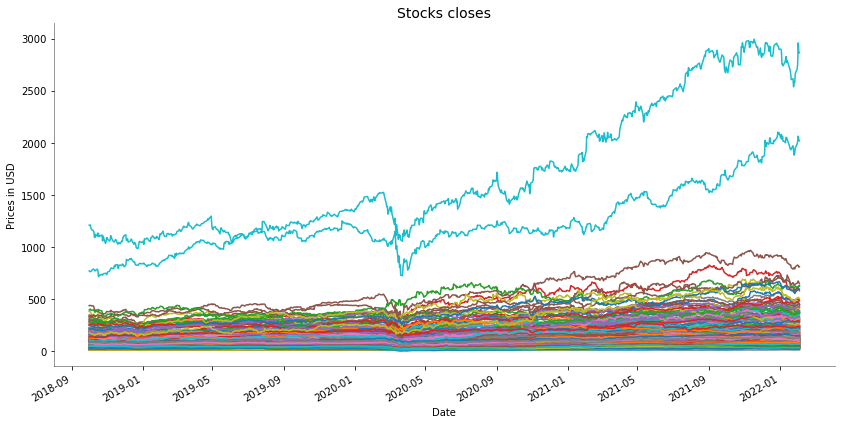

In [9]:
### Let's visualize our adjusted close prices in a graphic.
closes.plot(figsize=[14,7], legend=None)
plt.ylabel('Prices in USD')
plt.title('Stocks closes', fontsize=14)

### Matplotlib settings.
plt.gca().spines["top"].set_alpha(0.0)    
plt.gca().spines["bottom"].set_alpha(0.5)
plt.gca().spines["right"].set_alpha(0.0)    
plt.gca().spines["left"].set_alpha(0.5);

In [10]:
### Get the tickers with missing values, this tickers won't be useful for us.
missing_values = eda.dqr(closes)['missing_values']

missing_prices = {j:i for i,j in zip(missing_values, missing_values.index) if i > 0}

print('The tickers with missing values are: ')
print(f'We have a total of {len(missing_prices)} stocks with missing values')
missing_prices

The tickers with missing values are: 
We have a total of 7 stocks with missing values


{'AMCR': 62,
 'CTVA': 162,
 'DOW': 116,
 'FOX': 111,
 'FOXA': 110,
 'OGN': 659,
 'OTIS': 368}

As we can see we have $7$ tickers with missing prices, this means we can't work with them because that lack of information will affect the optimitazion. Let's drop them.

In [11]:
### Let's drop the tickers that won't be useful.
tickers_to_drop = [i for i in missing_prices.keys()]

closes_final = closes.drop(tickers_to_drop, axis=1)
closes_final.head(10)

,AAP,AAPL,ABBV,ABC,ABT,ADP,ADSK,AEE,AEP,AES,...,WM,WRB,WRK,WTW,XEL,XRAY,XYL,YUM,ZBRA,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2018-10-01,165.395813,54.893005,79.615486,87.696426,70.149605,140.706253,155.500000,58.162357,63.636288,12.630967,...,85.039810,48.895668,48.138844,135.566772,43.139660,36.714668,77.596390,85.462303,173.199997,45.037033
2018-10-02,164.225555,55.380917,78.970192,86.382751,69.856209,141.667709,153.919998,59.136475,64.040184,12.972589,...,84.813446,49.182262,47.932281,136.666595,43.716446,36.519787,77.375099,85.046425,168.990005,44.909843
2018-10-03,163.445389,56.054825,80.461937,86.033043,68.181023,141.499680,154.869995,58.529949,63.025948,13.062488,...,84.417343,49.319328,46.522243,136.618805,43.157970,36.130032,77.567535,84.838493,169.410004,46.136391
2018-10-04,161.602203,55.069324,78.643341,86.042519,67.972809,140.220871,152.100006,58.722946,63.331116,13.044509,...,83.964661,49.400326,46.333637,136.446655,43.441784,35.262833,77.259598,84.658913,165.199997,46.817806
2018-10-05,161.719223,54.175625,79.095894,85.607773,67.745667,140.939636,152.000000,59.825714,64.506897,13.179358,...,84.841751,49.070114,45.408592,135.566772,44.284069,35.408989,76.316589,85.065331,162.229996,46.490726
2018-10-08,164.186523,54.050018,79.456261,86.278801,67.613167,139.362106,146.210007,60.331158,65.386497,13.278248,...,85.709389,49.250797,44.124283,136.571014,44.659431,35.106934,74.805847,85.670242,158.500000,47.326595
2018-10-09,164.703415,54.798809,79.255135,85.929092,67.471191,140.146194,142.860001,60.956070,65.566002,13.323196,...,86.077217,49.437702,40.639606,136.370132,44.869999,34.834106,71.611160,86.180641,157.380005,46.945004
2018-10-10,159.125198,52.260185,78.006432,85.853493,65.228165,132.342667,133.500000,60.597656,65.251869,13.287238,...,85.162392,48.004726,39.184662,133.357559,44.714363,34.980267,69.417213,84.309196,149.580002,46.172737
2018-10-11,157.047958,51.798840,76.011833,82.517258,64.717087,128.982285,130.889999,58.851593,63.923508,12.981578,...,83.030991,46.359924,37.675831,130.134583,43.597420,34.765903,66.434219,82.295982,151.000000,44.682697


In [12]:
### Let´s calculate the returns.
ret = closes_final.pct_change().dropna()
ret.head(10)

,AAP,AAPL,ABBV,ABC,ABT,ADP,ADSK,AEE,AEP,AES,...,WM,WRB,WRK,WTW,XEL,XRAY,XYL,YUM,ZBRA,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2018-10-02,-0.007075,0.008888,-0.008105,-0.014980,-0.004182,0.006833,-0.010161,0.016748,0.006347,0.027046,...,-0.002662,0.005861,-0.004291,0.008113,0.013370,-0.005308,-0.002852,-0.004866,-0.024307,-0.002824
2018-10-03,-0.004751,0.012169,0.018890,-0.004048,-0.023980,-0.001186,0.006172,-0.010256,-0.015838,0.006930,...,-0.004670,0.002787,-0.029417,-0.000350,-0.012775,-0.010672,0.002487,-0.002445,0.002485,0.027311
2018-10-04,-0.011277,-0.017581,-0.022602,0.000110,-0.003054,-0.009038,-0.017886,0.003297,0.004842,-0.001376,...,-0.005362,0.001642,-0.004054,-0.001260,0.006576,-0.024002,-0.003970,-0.002117,-0.024851,0.014770
2018-10-05,0.000724,-0.016229,0.005754,-0.005053,-0.003342,0.005126,-0.000658,0.018779,0.018566,0.010338,...,0.010446,-0.006684,-0.019965,-0.006449,0.019389,0.004145,-0.012206,0.004801,-0.017978,-0.006986
2018-10-08,0.015257,-0.002319,0.004556,0.007838,-0.001956,-0.011193,-0.038092,0.008449,0.013636,0.007503,...,0.010227,0.003682,-0.028283,0.007408,0.008476,-0.008530,-0.019796,0.007111,-0.022992,0.017979
2018-10-09,0.003148,0.013854,-0.002531,-0.004053,-0.002100,0.005626,-0.022912,0.010358,0.002745,0.003385,...,0.004292,0.003795,-0.078974,-0.001471,0.004715,-0.007771,-0.042706,0.005958,-0.007066,-0.008063
2018-10-10,-0.033868,-0.046326,-0.015755,-0.000880,-0.033244,-0.055681,-0.065519,-0.005880,-0.004791,-0.002699,...,-0.010628,-0.028985,-0.035801,-0.022091,-0.003469,0.004196,-0.030637,-0.021715,-0.049562,-0.016450
2018-10-11,-0.013054,-0.008828,-0.025570,-0.038860,-0.007835,-0.025392,-0.019551,-0.028814,-0.020357,-0.023004,...,-0.025027,-0.034263,-0.038506,-0.024168,-0.024980,-0.006128,-0.042972,-0.023879,0.009493,-0.032271
2018-10-12,0.025336,0.035719,0.010586,0.013401,0.018062,0.018382,0.055696,-0.003748,-0.004493,0.014543,...,0.005793,-0.010886,0.015733,0.009039,0.000630,0.005325,0.010573,0.011255,0.044437,-0.019520


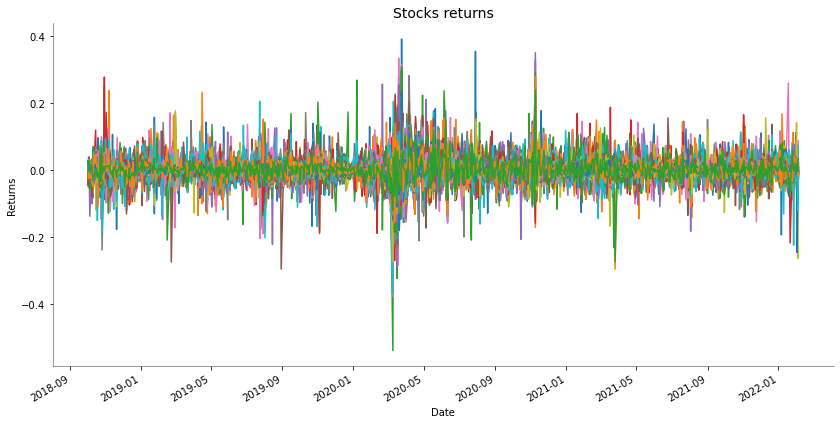

In [13]:
### Let's visualize our returns in a graphic
ret.plot(figsize=[14,7], legend=None)
plt.ylabel('Returns')
plt.title('Stocks returns', fontsize=14)

### Matplotlib settings.
plt.gca().spines["top"].set_alpha(0.0)    
plt.gca().spines["bottom"].set_alpha(0.5)
plt.gca().spines["right"].set_alpha(0.0)    
plt.gca().spines["left"].set_alpha(0.5);

**Minimal Variance Portfolio.**

Now we're trying to get the minimal variace portfolio, this portfolio as it own name says has particular characteristics, the minimal variace in the expected return / volatility space.

In [14]:
### Correlation matrix.
corr = ret.corr()
corr.head(10)

,AAP,AAPL,ABBV,ABC,ABT,ADP,ADSK,AEE,AEP,AES,...,WM,WRB,WRK,WTW,XEL,XRAY,XYL,YUM,ZBRA,ZION
AAP,1.000000,0.361651,0.346909,0.427969,0.326289,0.508548,0.358208,0.432093,0.394491,0.416313,...,0.422465,0.499252,0.457333,0.398983,0.426089,0.411340,0.503915,0.459589,0.376250,0.425468
AAPL,0.361651,1.000000,0.413006,0.385185,0.545764,0.572569,0.607541,0.385823,0.321637,0.379749,...,0.434408,0.443244,0.374288,0.439574,0.393721,0.324450,0.499903,0.426541,0.567155,0.274730
ABBV,0.346909,0.413006,1.000000,0.440585,0.490697,0.463929,0.402874,0.325154,0.288961,0.340048,...,0.436979,0.407463,0.331635,0.352239,0.345996,0.400516,0.378813,0.339372,0.383893,0.313721
ABC,0.427969,0.385185,0.440585,1.000000,0.464092,0.524591,0.383831,0.442090,0.401749,0.372243,...,0.515926,0.547390,0.472675,0.426850,0.435282,0.472456,0.483260,0.401012,0.382491,0.412127
ABT,0.326289,0.545764,0.490697,0.464092,1.000000,0.578240,0.475459,0.496630,0.443165,0.309546,...,0.540385,0.488156,0.324711,0.473433,0.509007,0.347787,0.500912,0.425105,0.484911,0.241710
ADP,0.508548,0.572569,0.463929,0.524591,0.578240,1.000000,0.571088,0.559789,0.504053,0.506205,...,0.654928,0.654308,0.518181,0.547425,0.550433,0.483134,0.645204,0.570259,0.540380,0.453210
ADSK,0.358208,0.607541,0.402874,0.383831,0.475459,0.571088,1.000000,0.288837,0.234071,0.428314,...,0.431299,0.418297,0.418944,0.428070,0.291172,0.358350,0.528023,0.410408,0.585149,0.306771
AEE,0.432093,0.385823,0.325154,0.442090,0.496630,0.559789,0.288837,1.000000,0.842484,0.449100,...,0.635728,0.590694,0.400971,0.468043,0.875169,0.351009,0.492411,0.417658,0.327435,0.293011
AEP,0.394491,0.321637,0.288961,0.401749,0.443165,0.504053,0.234071,0.842484,1.000000,0.391914,...,0.630902,0.549773,0.352097,0.421100,0.840838,0.333463,0.428290,0.383646,0.252507,0.288453
AES,0.416313,0.379749,0.340048,0.372243,0.309546,0.506205,0.428314,0.449100,0.391914,1.000000,...,0.496476,0.576394,0.546444,0.462317,0.428615,0.455970,0.525174,0.463462,0.452715,0.485853


In [15]:
### Let's calculate our anual returns and our anual std. deviation for every asset.
annual = pd.DataFrame({'$E[r]$':ret.mean()*252, '$\sigma$':ret.std()*np.sqrt(252)})
annual = annual.T
annual

,AAP,AAPL,ABBV,ABC,ABT,ADP,ADSK,AEE,AEP,AES,...,WM,WRB,WRK,WTW,XEL,XRAY,XYL,YUM,ZBRA,ZION
$E[r]$,0.153678,0.402461,0.210775,0.182306,0.223286,0.160195,0.213185,0.157682,0.131628,0.239408,...,0.186850,0.230467,0.086365,0.210414,0.172898,0.164653,0.099884,0.153834,0.398973,0.222239
$\sigma$,0.341725,0.346686,0.282807,0.316424,0.281164,0.301752,0.403305,0.274502,0.247993,0.383870,...,0.232758,0.311927,0.455520,0.291240,0.257808,0.345157,0.327593,0.284352,0.400425,0.416163


**Risk free rate.**

For the purpose of this portfolio analysis, let's take the one year rate (we use it for the day 07/02/22). You can consult it from Factset.

[U.S Government Yields](https://my.apps.factset.com/navigator/markets/government-yields)

In [16]:
### Risk free rate.
rf = 0.8475/100

In [17]:
### From the mean variance dataframe called annual. 
# We create a matrix which the main diagonal is going to be the std. deviation of the assets.
# This will help us to calculate the std. deviation of our portfolio.
S = np.diag(annual.loc['$\sigma$'])

In [18]:
### Building the parameters.
# 1. Variance-Covariance matrix Sigma its equal to:
# Sigma = S.dot(corr).dot(S)
Sigma = S.dot(corr).dot(S)

# 3. Eind: expected returns of individual assets
Eind = annual.loc['$E[r]$']

In [19]:
### Building the minimun variance frontier.
# Objective function.
def var(w,Sigma):
    
    ''' Sigma is the variance-covariance matrix'''
    ''' w is a vector that contains the weights of each asset in the portfolio'''
    
    return w.T.dot(Sigma).dot(w)

In [20]:
### Initial values. Let's start from 1%.
w0 = np.ones(len(Eind))/len(Eind)

### Variables limits. Let's define a maximum of 17% weight
bnd = ((0,0.17),)*len(Eind)

### Restrictions.
cons = ({'type':'eq','fun': lambda w: np.sum(w)-1},)

In [21]:
### Optimization.
# Minimal Variance Portfolio.
minvar = minimize(fun=var,x0=w0,args=(Sigma,),bounds=bnd,constraints=cons)

In [22]:
### Weights.
w_minvar = minvar.x

### Portfolio risk.
s_minvar = (var(w_minvar,Sigma))**(0.5)

### Expected return.
E_minvar = Eind.dot(w_minvar)

### Sharpe ratio.
RS_minvar=(E_minvar-rf)/s_minvar

minvar_data = pd.DataFrame({'$\sigma$':s_minvar, '$E[r]$':E_minvar,'Sharpe ratio':RS_minvar},
                            index=['Minimal Variance Portfolio'])
minvar_data.T

,Minimal Variance Portfolio
$\sigma$,0.144939
$E[r]$,0.164424
Sharpe ratio,1.075963


**Efficient Mean Variance Portfolio.**

In [23]:
### Objective function.
# Now the optimization is respect to the sharpe ratio.
def menos_RS(w,Eind,Sigma,rf):
    
    ''' w is a vector that contain the weights of each asset in the portfolio '''
    ''' Eind expected returns of individual assets '''
    ''' Sigma: Variace-Covariance Matrix '''
    ''' rf: risk free rate '''
    
    return -((Eind.T.dot(w))-rf)/((w.T.dot(Sigma).dot(w))**(0.5))

In [24]:
### Portfolio EMV.
EMV = minimize(fun=menos_RS,x0=w0,args=(Eind,Sigma,rf,),bounds=bnd,constraints=cons)

In [25]:
### Weights.
W_EMV = EMV.x

### Portfolio Expected return.
E_EMV = Eind.T.dot(W_EMV)

### Portfolio risk.
S_EMV = var(W_EMV,Sigma)**0.5

### Sharpe ratio.
RS_EMV = (E_EMV-rf)/S_EMV

P_EMV = pd.DataFrame({'$E[r]$':E_EMV, '$\sigma$':S_EMV,'Sharpe ratio':RS_EMV},index=['EMV Portfolio'])
P_EMV.T

,EMV Portfolio
$E[r]$,0.345934
$\sigma$,0.182352
Sharpe ratio,1.850592


**Building the frontier.**

Now we're looking for the minimal variance frontier, let's build it.

In [26]:
### Covariance between the portfolios.
cov_EMV_minvar = W_EMV.dot(Sigma).dot(w_minvar)
print(f'The covariance between portfolios: {cov_EMV_minvar*100}%')

The covariance between portfolios: 2.274601099213492%


In [27]:
### Correlation between portfolios.
corr_EMV_minvar = cov_EMV_minvar/(S_EMV*s_minvar)
print(f'The correlation between portfolios: {corr_EMV_minvar*100}%')

The correlation between portfolios: 86.06132664408449%


In [28]:
### Portfolios dataframe. 
# Vector of weights.
wp = np.linspace(0,1,1000)

fron_min_var = pd.DataFrame({'W':wp,'W(minvar)':1-wp,'$E[r]$':E_EMV*wp+(1-wp)*E_minvar,
                             '$\sigma$':(((wp*S_EMV)**2+(1-wp)**2*s_minvar**2+2*wp*(1-wp)*cov_EMV_minvar)**0.5),
                             'SR':((E_EMV*wp+(1-wp)*E_minvar)-rf)/((((wp*S_EMV)**2+(1-wp)**2*s_minvar**2+2*wp*(1-wp)*cov_EMV_minvar)**0.5))})
fron_min_var

,W,W(minvar),$E[r]$,$\sigma$,SR
0,0.000000,1.000000,0.164424,0.144939,1.075963
1,0.001001,0.998999,0.164606,0.144951,1.077127
2,0.002002,0.997998,0.164788,0.144964,1.078290
3,0.003003,0.996997,0.164969,0.144976,1.079453
4,0.004004,0.995996,0.165151,0.144988,1.080615
...,...,...,...,...,...
995,0.995996,0.004004,0.345208,0.182122,1.848944
996,0.996997,0.003003,0.345389,0.182179,1.849357
997,0.997998,0.002002,0.345571,0.182237,1.849769
998,0.998999,0.001001,0.345753,0.182294,1.850181


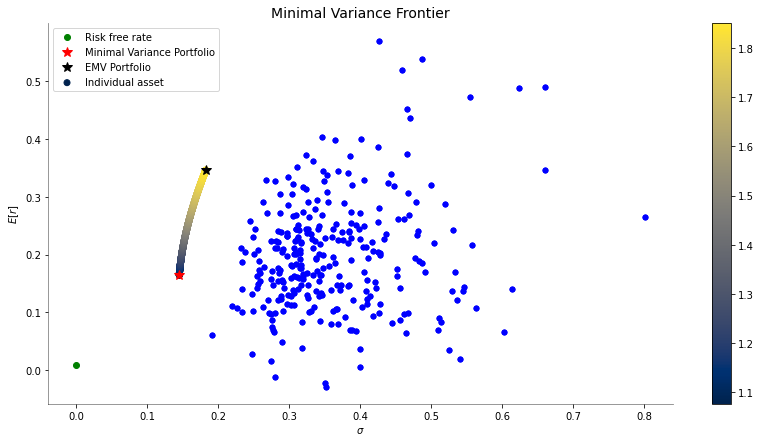

In [29]:
### Plotting the portfolios.
plt.figure(figsize=(14,7))
plt.xlabel('$\sigma$')
plt.ylabel('$E[r]$')

# Free risk rate.
plt.plot(0,rf,'og',label='Risk free rate')

# Minvar portfolio.
plt.plot(s_minvar,E_minvar,'*r',ms=10, label='Minimal Variance Portfolio')

# EMV portfolio.
plt.plot(S_EMV,E_EMV,'*k',ms=10, label='EMV Portfolio')

# Assets.
for i in range(len(annual)):
    plt.plot(annual.loc['$\sigma$'],annual.loc['$E[r]$'],'ob',ms=5)
    
plt.scatter(fron_min_var['$\sigma$'],fron_min_var['$E[r]$'],c=fron_min_var['SR'],cmap='cividis',label='Individual asset')
plt.colorbar()
plt.legend(loc='best')
plt.title('Minimal Variance Frontier', fontsize=14)

### Matplotlib settings.
plt.gca().spines["top"].set_alpha(0.0)    
plt.gca().spines["bottom"].set_alpha(0.5)
plt.gca().spines["right"].set_alpha(0.0)    
plt.gca().spines["left"].set_alpha(0.5);

**Capital Asignation Line.**

With the analysis that we previously developed the captial asignation line will give us the optimal portfolio depending on our risk aversion coefficient, the weightins that this process returns includes the risk free rate as a possible investment. For the purpose of this tutorial we´re interested in the assets that aren´t risk free, that´s why the final output of this document will be a dataframe with the name of the assets and their respective weights on the particular portfolio.

In order to get the optimal asignation of capital, we need to know our risk aversion coefficent. [You can check yours here](https://www.wsj.com/articles/check-your-tolerance-for-investment-risk-now-before-markets-sag-1405619939)

For practical reasons, let's assume we have risk aversion coefficient of $8$.

In [30]:
### Let's build our CAL.
LAC = pd.DataFrame({'w(EMV)': wp,
                    'w(rf)': 1 - wp,
                    '$E[r]$': wp * E_EMV + (1 - wp) * rf,
                    '$\sigma$': wp * S_EMV
                   })

LAC['RS'] = (LAC['$E[r]$'] - rf) / LAC['$\sigma$']
LAC.head()

,w(EMV),w(rf),$E[r]$,$\sigma$,RS
0,0.000000,1.000000,0.008475,0.000000,NaN
1,0.001001,0.998999,0.008813,0.000183,1.850592
2,0.002002,0.997998,0.009151,0.000365,1.850592
3,0.003003,0.996997,0.009488,0.000548,1.850592
4,0.004004,0.995996,0.009826,0.000730,1.850592


In [31]:
### Now let´s see how much invest in our assets portfolio and how much for the risk free rate.
gamma = 8
w_client = (E_EMV - rf) / (gamma * S_EMV**2)

# Dataframe
asignation_C = pd.DataFrame({'w(EMV)': w_client*100,
                             'w(rf)': (1 - w_client)*100,
                             'Gamma': gamma},
                             index = ['Capital Asignation in %'])
asignation_C

,w(EMV),w(rf),Gamma
Capital Asignation in %,126.855752,-26.855752,8


In [32]:
### Results.
print(f'The optimal investment in our EMV portfolio is: {w_client*100}%')
print(f'The optimal investment in our risk free rate is: {(1-w_client)*100}%')

The optimal investment in our EMV portfolio is: 126.85575213988326%
The optimal investment in our risk free rate is: -26.855752139883272%


Now let´s see the particular weights in our EMV portfolio.

In [33]:
### Let's get the weigths and their respective asset.
tickers_final = closes_final.columns.tolist()
EMV_port = {i: EMV.x[j]*100 for i,j in zip(tickers_final, range(len(tickers_final)))}
EMV_df_final = pd.DataFrame.from_dict(EMV_port, orient='index', columns=['Weights in %'])
EMV_df_final.index.name = 'Stocks'

print('This is the top 10 assets position:')
EMV_df_final.sort_values(by=['Weights in %'], ascending=False).head(10)

This is the top 10 assets position:


,Weights in %
Stocks,
EXR,16.835055
NEM,14.757670
GNRC,12.619349
NLOK,10.487521
KR,10.141033
DHR,8.245151
LLY,7.641301
SBNY,5.700647
AZO,5.399494


This is the top 10 positions:


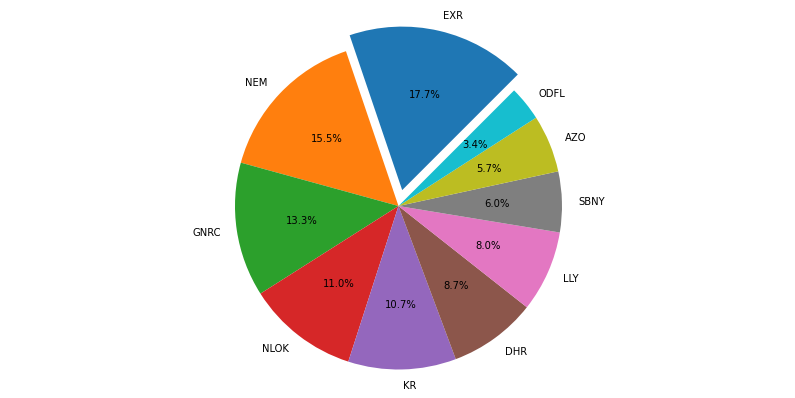

In [34]:
### Let's plot a pie chart to visualize the portfolio.
EMV_10 = EMV_df_final.sort_values(by=['Weights in %'], ascending=False).head(10)
labels_portfolio = EMV_10.T.columns.tolist()
sizes_portfolio = EMV_10.T.values.flatten().tolist()
explode_portfolio = (0.1, 0, 0, 0, 0, 0, 0, 0, 0, 0) 

fig1_emv, ax1_emv = plt.subplots(figsize=[14,7])
ax1_emv.pie(sizes_portfolio, explode=explode_portfolio, labels=labels_portfolio, autopct='%1.1f%%',
            shadow=False, startangle=45, normalize=True)

ax1_emv.axis('equal')

print('This is the top 10 positions:')
plt.show()

In [35]:
### Final product of the document. This command will export a csv file on your repository carpet.
EMV_df_final.to_csv('Portfolio_weights.csv')

-------------------------------------------------------------------------------------------------------------------------------

$$\color{grey}{\text{Sociedad de Alumnos de Ingeniería Financiera.}}$$

-------------------------------------------------------------------------------------------------------------------------------